### Description: Computes GSA sensitvity indices using PCE surrogate construction using projection (Gaussian Quadrature)
#### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com
#### Additional packages required: [UQTk](www.sandia.gov)

This code deals with computing Sobol sensitivity indices using PCE surrogate. The coefficeints of the PCE surrogate are computed using the projection approach. The model considered for this code is:
$$Y = \sin X_1 + a\sin^2 X_2 + b X_3^2 \sin X_1 $$
where the input vector is $\{X_1,X_2,X_3\}$ anr uniform($-\pi,\pi$) and parameters $a = 7.0$ and $b = 0.1$ are known constants. The analytical solution to the Sobol sensitvity indices is known:
$$Var(Y)  = \frac{1}{2} + \frac{a^2}{8} + \frac{b\pi^4}{5} + \frac{b^2\pi^8}{18} $$
$$SI_1 =  \left(\frac{1}{2} + \frac{b\pi^4}{5} + + \frac{b^2\pi^8}{50}\right)/ Var(Y)$$
$$SI_2  =  \left(\frac{a^2}{8}\right)/Var(Y)  $$
$$SI_{13}  = \left(\frac{b^2\pi^8}{18} -  \frac{b^2\pi^8}{50}\right)/Var(Y) $$
$$SI_3 = SI_{12} = SI_{23} = SI_{123} = 0 $$
The best choice for reasonable estimate of sensitvity indices: Minimum PCE order = 6, needs minimum 7 level tensor-gird quadrature LU (343 quadrature points).

In [61]:
#!/usr/bin/python
from numpy import *
import matplotlib.pyplot as plt
import os
import math
import sys

Defines the function and the input distribution for the give case:

In [62]:
def Ishigami(x):
    dim = 3
    Mpar = [7.0, 0.1]
    PdfType = ['u','u','u']
    Xpar = zeros((dim,2))
    Xpar[0,:] = [-pi,pi]
    Xpar[1,:] = [-pi,pi]
    Xpar[2,:] = [-pi,pi]
    SI = zeros((2,dim))
    var1 = 0.5+Mpar[1]*pi**4/5 + Mpar[1]**2*pi**8/50
    var2 = Mpar[0]**2/8
    var13 =Mpar[1]**2*pi**8/18 - Mpar[1]**2*pi**8/50
    SI[0,0] = var1/(var1 + var2 + var13)
    SI[0,1] = var2/(var1 + var2 + var13)
    SI[0,2] = 0.0
    SI[1,0] = SI[0,0] + var13/(var1 + var2 + var13)
    SI[1,1] = SI[0,1]
    SI[1,2] = SI[0,2] + var13/(var1 + var2 + var13)
    label = [r'$X_1$',r'$X_2$',r'$X_3$']
    if isinstance(x,int):
        return dim,PdfType,Xpar,SI,label
    else: 
        return sin(x[:,0]) + 7.0*(sin(x[:,1]))**2 + 0.1*(x[:,2]**4)*sin(x[:,0])

PCE Projection/Quadrature set up (UQTk quadrature type options: 'LU', 'HG', 'CC', 'CCO', 'NC', 'NCO'):

In [63]:
f  = Ishigami # name of model (defined above)
PCtype = 'LU' # type of PC basis
p  = 6 # order of PCE expansion

In [64]:
Qtype  = 'LU' # type of quadrature
Qstype = 'full'# sparse or tensor grid
Qlvl   = 7 #level of quadrature
outLog = ' >> out.log'
set_printoptions(precision=3,suppress=True)
plotPdf =1

Extract model/parameter info and print it:

In [65]:
d,Xpdftype,Xpdfpar,SI,Xlabel = f(0)
SIest = zeros((2,d))
SIerr = zeros((2,d))
os.system('rm *.dat data/* *.pyc'+outLog)
print('Dimension : ', d)
for i in range(0,d):
    print('Parameter : ', Xlabel[i],Xpdftype[i],Xpdfpar[i,:])

Dimension :  3
Parameter :  $X_1$ u [-3.142  3.142]
Parameter :  $X_2$ u [-3.142  3.142]
Parameter :  $X_3$ u [-3.142  3.142]


Generate quadrature points using UQtk (outputs into a file) and load them, and then convert them into points from given nonstandard distribution:

In [66]:
CMD = 'generate_quad -g '+Qtype+' -p '+str(Qlvl)+' -d '+str(d)+' -x '+Qstype
os.system(CMD+outLog)
Xwts = loadtxt('wghts.dat')
Xpts = zeros((len(Xwts),d))
Xpts_std = loadtxt('qdpts.dat')

In [67]:
for i in range(0,d):
    if Xpdftype[i] == 'u':
        if d==1:
            Xpts[:,i] = 0.5*(Xpdfpar[i,0] + Xpdfpar[i,1]) + 0.5*(Xpdfpar[i,1] - Xpdfpar[i,0])*Xpts_std
        else:
            Xpts[:,i] = 0.5*(Xpdfpar[i,0] + Xpdfpar[i,1]) + 0.5*(Xpdfpar[i,1] - Xpdfpar[i,0])*Xpts_std[:,i]
    elif Xpdftype[i] == 'n':
        Xpts[:,i] = Xpdfpar[i,0] + sqrt(Xpdfpar[i,1])*Xpts_std[:,i]
Yvals = f(Xpts)
savetxt('ydata.dat',Yvals)

Computes PCE coefficients, read then from file, compute L2 norm, and print the results:

In [68]:
CMD = 'pce_resp -e -x '+PCtype+' -d'+str(d)+' -o'+str(p)
os.system(CMD+outLog)
PCcoeff = loadtxt('PCcoeff_quad.dat')
PCmindex = loadtxt('mindex.dat')
Ypc =loadtxt('ydata_pc.dat')
L2norm = linalg.norm(multiply(sqrt(Xwts),Yvals - Ypc),2)
PCtermsNZ = sum(1 for i in PCcoeff if abs(i) > 1e-05)

In [69]:
print('PCE type   : ',PCtype,'\nPCE Dim    : ',d,'\nPCE Order  : ',p,'\n# PCE terms: ',len(PCcoeff))
print('-------------------')
print('Quad type  : ',Qtype,'\nSparse grd?: ',Qstype,'\nQuad Level : ',Qlvl,'\n#  qpoints : ',Xpts.shape[0])
print('-------------------')
print('Non-zero PCE coeffs: (',PCtermsNZ,'/', len(PCcoeff),')')
for i,mi in enumerate(PCmindex):
    if abs(PCcoeff[i]) > 1e-05:
        print('{:5d}'.format(i),' : ', mi.astype(int),' : ', '{:8.3f}'.format(PCcoeff[i]))
print('-------------------')
print('L2 Error   : ', L2norm)
os.system('mv ydata.dat ydata_qdpts.dat')
os.system('mv ydata_pc.dat ydata_qdpts_pc.dat');

PCE type   :  LU 
PCE Dim    :  3 
PCE Order  :  6 
# PCE terms:  84
-------------------
Quad type  :  LU 
Sparse grd?:  full 
Quad Level :  7 
#  qpoints :  343
-------------------
Non-zero PCE coeffs: ( 10 / 84 )
    0  :  [0 0 0]  :     3.500
    1  :  [1 0 0]  :     2.815
    7  :  [0 2 0]  :    -1.321
   10  :  [3 0 0]  :    -3.415
   15  :  [1 0 2]  :     5.315
   30  :  [0 4 0]  :    -5.995
   35  :  [5 0 0]  :     0.645
   40  :  [3 0 2]  :    -6.447
   49  :  [1 0 4]  :     2.126
   77  :  [0 6 0]  :     6.118
-------------------
L2 Error   :  0.367308995962144


Compute sensitvity indices using PCE coefficients and print the estimated vs analytical SI values:


S_i  (Ex.):  [0.314 0.442 0.   ] 
S_Ti (Ex.):  [0.558 0.442 0.244]
S_i  (PCE):  [0.293 0.488 0.   ] 
S_Ti (PCE):  [0.512 0.488 0.219]
S_i (err%):  [ 6.5   10.252  0.   ] 
S_Ti(err%):  [ 8.135 10.252 10.24 ]


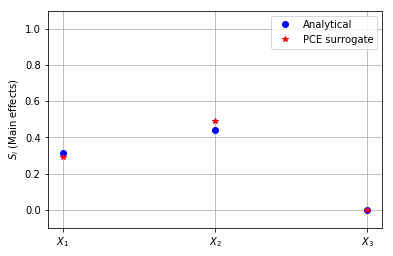

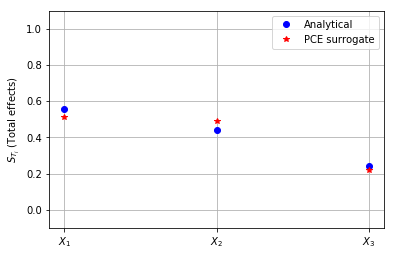

In [72]:
if d > 1:
    CMD = 'pce_sens -m mindex.dat -f PCcoeff_quad.dat -x'+PCtype
    os.system(CMD+outLog)
    SIest[0,:] = loadtxt('mainsens.dat')
    SIest[1,:] = loadtxt('totsens.dat')
    for i in range(0,d):
        for ii in range(0,2):
            if SI[ii,i] > 1e-02: 
                SIerr[ii,i] = 100*abs(SIest[ii,i] - SI[ii,i])/SI[ii,i]
            else:
                SIerr[ii,i] = 0.0 
    print('\nS_i  (Ex.): ', SI[0,:],'\nS_Ti (Ex.): ', SI[1,:])
    print('S_i  (PCE): ', SIest[0,:],'\nS_Ti (PCE): ', SIest[1,:])
    print('S_i (err%): ', SIerr[0,:],'\nS_Ti(err%): ', SIerr[1,:])
    fig = plt.figure(1)
    x =range(1,d+1)
    plt.plot(x,SI[0,:],'bo',label='Analytical')
    plt.plot(x,SIest[0,:],'r*',label='PCE surrogate')
    plt.grid(True)
    plt.ylim(-0.1,1.1)
    plt.ylabel(r'$S_i$ (Main effects)')
    plt.legend(loc='best', numpoints = 1)
    plt.xticks(x,Xlabel)
    plt.savefig('GSA_PCE_foSI.pdf',bbox_inches='tight')
    fig = plt.figure(2)
    x =range(1,d+1)
    plt.plot(x,SI[1,:],'bo',label='Analytical')
    plt.plot(x,SIest[1,:],'r*',label='PCE surrogate')
    plt.grid(True)
    plt.ylim(-0.1,1.1)
    plt.legend(loc='best', numpoints = 1)
    plt.ylabel(r'$S_{T_i}$ (Total effects)')
    plt.xticks(x,Xlabel)
    plt.savefig('GSA_PCE_toSI.pdf',bbox_inches='tight')

Plotting the true vs PCE surrogate pdf of the output Y, this checks for goodness of PCE surrogate, along with L2 error above:  

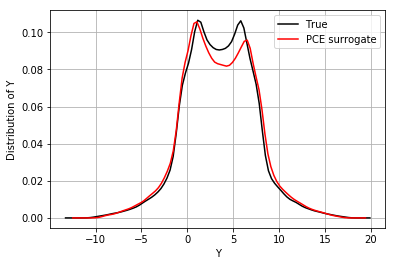

In [73]:
if plotPdf == 1:
    M = 100000
    Xspls = zeros((M,d))
    Xspls_std = zeros((M,d))
    for i in range(0,d):
        RndSeed = 100+i
        if (Xpdftype[i] == 'u'):
            CMD1 = 'trdSpls -a -1 -b 1 -n '+str(M)+' -i '+str(RndSeed)+' -f spls.dat -t u'
            os.system(CMD1)
            Xstd = loadtxt('spls.dat')
            Xnew = 0.5*(Xpdfpar[i,0] + Xpdfpar[i,1]) + 0.5*(Xpdfpar[i,1] - Xpdfpar[i,0])*Xstd
        elif (Xpdftype[i] == 'n'):
            CMD1 = 'trdSpls -a '+str(-100000)+' -b '+str(100000) \
                    +' -m 0 -s 1 -n '+str(M)+' -i '+str(RndSeed)+' -f spls.dat  -t n'
            os.system(CMD1)
            Xstd = loadtxt('spls.dat')
            Xnew = Xpdfpar[i,0] + sqrt(Xpdfpar[i,1])*Xstd
        Xspls[:,i] = Xnew
        Xspls_std[:,i] = Xstd
    os.system('rm spls.dat')
    Ymc = f(Xspls)
    savetxt('ydata_mc.dat',Ymc)
    savetxt('xdata.dat',Xspls_std)
    CMD6 = 'pdf_cl -i ydata_mc.dat'
    os.system(CMD6)
    YmcDens = loadtxt('dens.dat')
    CMD7 = 'pce_eval -x PC_mi -f PCcoeff_quad.dat -o '+str(p)+' -s '+PCtype
    os.system(CMD7+outLog)
    os.system('mv ydata.dat ydata_mc_pc.dat')
    CMD8 = 'pdf_cl -i ydata_mc_pc.dat'
    os.system(CMD8)
    YmcpcDens = loadtxt('dens.dat')
    fig = plt.figure(3)
    plt.plot(YmcDens[:,0],YmcDens[:,1],'k-',label='True')
    plt.plot(YmcpcDens[:,0],YmcpcDens[:,1],'r-',label='PCE surrogate')
    plt.grid(True)
    plt.legend(loc='best', numpoints = 1)
    plt.ylabel('Distribution of Y')
    plt.xlabel('Y')
    plt.savefig('GSA_PCE_projection_ydens.pdf',bbox_inches='tight')